In [1]:
import copy
import dnnlib
from torch_utils import misc
from torch_utils.ops import conv2d_gradfix
from torch_utils.ops import grid_sample_gradfix
from networks import legacy
from networks.stylegan2 import Generator as Stylegan2Generator
from networks.stylegan2 import Discriminator as Stylegan2Discriminator
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
from networks.encoders import ResnetEncoder
from networks.FLAME import FLAME, FLAMETex
from networks.decoders import Generator
from utils import util
from utils.rotation_converter import batch_euler2axis
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from utils.renderer import SRenderY
import torch
import torch.nn as nn
# %%
import os
import copy
import pickle
import numpy as np
import torch

import os, sys
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
from utils.rotation_converter import batch_euler2axis
from utils.tensor_cropper import transform_points
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from torch.utils.data import Dataset, DataLoader
from networks.UVGan import UVGan
from munch import DefaultMunch
import warnings
warnings.filterwarnings('ignore')

import albumentations as albu
import albumentations.pytorch
import logging
from torch.optim.lr_scheduler import MultiStepLR




In [2]:
import copy
import dnnlib
from torch_utils import misc
from torch_utils.ops import conv2d_gradfix
from torch_utils.ops import grid_sample_gradfix
from networks import legacy
from networks.stylegan2 import Generator as Stylegan2Generator
from networks.stylegan2 import Discriminator as Stylegan2Discriminator
import os
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from time import time
from skimage.io import imread
import cv2
import pickle
from networks.encoders import ResnetEncoder
from networks.FLAME import FLAME, FLAMETex
from networks.decoders import Generator
from utils import util
from utils.rotation_converter import batch_euler2axis
from utils.config import cfg
torch.backends.cudnn.benchmark = True
from utils.renderer import SRenderY
import torch
import torch.nn as nn



In [3]:

class Renderer(nn.Module):
    def __init__(self, config=None):
        super().__init__()

        self.cfg = config
        self.device = "cuda:0"
        self.image_size = self.cfg.image_size
        self.image_channels = 3
        self.condition_dim = 0
        self.uv_size = self.cfg.uv_size

        mask = cv2.imread(self.cfg.face_eye_mask_path).astype(np.float32)/255.
        mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_eye_mask = F.interpolate(mask, [self.uv_size, self.uv_size]).to(self.device)

        self._setup_renderer(self.cfg)

    def _setup_renderer(self, cfg):
        self.render = SRenderY(self.image_size, obj_filename=cfg.topology_path, uv_size=cfg.uv_size, rasterizer_type="pytorch3d").to(self.device)
        # face mask for rendering details
        mask = imread(cfg.face_eye_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_eye_mask = F.interpolate(mask, [cfg.uv_size, cfg.uv_size]).to(self.device)
        mask = imread(cfg.face_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
        self.uv_face_mask = F.interpolate(mask, [cfg.uv_size, cfg.uv_size]).to(self.device)
        # displacement correction
        fixed_dis = np.load(cfg.fixed_displacement_path)
        self.fixed_uv_dis = torch.tensor(fixed_dis).float().to(self.device)
        # dense mesh template, for save detail mesh
        self.dense_template = np.load(cfg.dense_template_path, allow_pickle=True, encoding='latin1').item()        

    def displacement2normal(self, uv_z, coarse_verts, coarse_normals):
        ''' Convert displacement map into detail normal map
        '''
        batch_size = uv_z.shape[0]
        uv_coarse_vertices = self.render.world2uv(coarse_verts).detach()
        uv_coarse_normals = self.render.world2uv(coarse_normals).detach()
    
        uv_z = uv_z*self.uv_face_eye_mask
        uv_detail_vertices = uv_coarse_vertices + uv_z*uv_coarse_normals + self.fixed_uv_dis[None,None,:,:]*uv_coarse_normals.detach()
        dense_vertices = uv_detail_vertices.permute(0,2,3,1).reshape([batch_size, -1, 3])
        uv_detail_normals = util.vertex_normals(dense_vertices, self.render.dense_faces.expand(batch_size, -1, -1))
        uv_detail_normals = uv_detail_normals.reshape([batch_size, uv_coarse_vertices.shape[2], uv_coarse_vertices.shape[3], 3]).permute(0,3,1,2)
        uv_detail_normals = uv_detail_normals*self.uv_face_eye_mask + uv_coarse_normals*(1-self.uv_face_eye_mask)
        return uv_detail_normals


cfg_dict = {
  "device": "cuda:0",
  "topology_path": '/src/deca/DECA/data/head_template.obj',
  'dense_template_path': '/src/deca/DECA/data/texture_data_256.npy',
  'fixed_displacement_path': '/src/deca/DECA/data/fixed_displacement_256.npy',
  'flame_model_path': '/src/deca/DECA/data/generic_model.pkl',
  'flame_lmk_embedding_path': '/src/deca/DECA/data/landmark_embedding.npy',
  'face_mask_path': '/src/deca/DECA/data/uv_face_mask.png',
  'face_eye_mask_path': '/src/deca/DECA/data/uv_face_eye_mask.png',
  'image_size': 256,
  'uv_size' : 256,
}
cfg = DefaultMunch.fromDict(cfg_dict)

renderer = Renderer(cfg)



KeyboardInterrupt: 

In [ ]:
device = "cuda:0"
batch_size = 5

In [ ]:

############################
# DECA
############################
cfg_dict = {
  "save_dir" : "./snapshots/snapshot-uv/aligned_snapshot_lpips",
  "device": "cuda:0",
  "random_seed": 0,
  "epochs": 50,
  "DECA_kwargs": {
    "pretrained_model" : '/src/deca/DECA/data/deca_model.tar',
    "topology_path": '/src/deca/DECA/data/head_template.obj',
    'dense_template_path': '/src/deca/DECA/data/texture_data_256.npy',
    'fixed_displacement_path': '/src/deca/DECA/data/fixed_displacement_256.npy',
    'flame_model_path': '/src/deca/DECA/data/generic_model.pkl',
    'flame_lmk_embedding_path': '/src/deca/DECA/data/landmark_embedding.npy',
    'face_mask_path': '/src/deca/DECA/data/uv_face_mask.png',
    'face_eye_mask_path': '/src/deca/DECA/data/uv_face_eye_mask.png',
    'mean_tex_path': '/src/deca/DECA/data/mean_texture.jpg',
    'tex_path': '/src/deca/DECA/data/FLAME_albedo_from_BFM.npz',
    'tex_type': 'BFM',
    'image_size': 224,
    'uv_size': 256,
    'param_list': ['shape', 'tex', 'exp', 'pose', 'cam', 'light'],
    'n_shape': 100,
    'n_tex': 50,
    'n_exp': 50,
    'n_cam': 3,
    'n_pose': 6,
    'n_light': 27,
    'use_tex': True, 
    'jaw_type': 'aa',
    'fr_model_path': '/src/deca/DECA/data/resnet50_ft_weight.pkl', 
    'n_detail': 128, 
    'max_z': 0.01,
    'jaw_type' : 'euler'
  }
}
cfg = DefaultMunch.fromDict(cfg_dict)

# DECA set up parameters
n_shape = cfg.DECA_kwargs.n_shape
n_tex = cfg.DECA_kwargs.n_tex
n_exp = cfg.DECA_kwargs.n_exp
n_pose = cfg.DECA_kwargs.n_pose
n_cam = cfg.DECA_kwargs.n_cam
n_light = cfg.DECA_kwargs.n_light
uv_size = 256
n_detail = cfg.DECA_kwargs.n_detail
n_cond = n_exp + 3 # exp + jaw pose
max_z = cfg.DECA_kwargs.max_z

num_list = [n_shape, n_tex, n_exp, n_pose, n_cam, n_light]
param_dict = {i:cfg.DECA_kwargs.get('n_' + i) for i in cfg.DECA_kwargs.param_list}

# DECA decoders
flame = FLAME(cfg.DECA_kwargs).to(device)
DECA_detail = Generator(latent_dim=n_detail+n_cond, out_channels=1, out_scale=max_z, sample_mode = 'bilinear').to(device)
flametex = FLAMETex(cfg.DECA_kwargs).to(device)

# resume deca model
model_path_deca = cfg.DECA_kwargs.pretrained_model
if os.path.exists(model_path_deca):
    print(f'DECA trained model found. load {model_path_deca}')
    checkpoint = torch.load(model_path_deca)
    checkpoint = checkpoint
    util.copy_state_dict(DECA_detail.state_dict(), checkpoint['D_detail'])
else:
    print(f'DECA trained model not found please check model path: {model_path_deca}')
    
DECA_detail.eval()


image_size = 256
render = SRenderY(image_size, obj_filename=cfg.DECA_kwargs.topology_path, uv_size=cfg.DECA_kwargs.uv_size, rasterizer_type="pytorch3d").to(device)
# face mask for rendering details
mask = imread(cfg.DECA_kwargs.face_eye_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
uv_face_eye_mask = F.interpolate(mask, [cfg.DECA_kwargs.uv_size, cfg.DECA_kwargs.uv_size]).to(device)
mask = imread(cfg.DECA_kwargs.face_mask_path).astype(np.float32)/255.; mask = torch.from_numpy(mask[:,:,0])[None,None,:,:].contiguous()
uv_face_mask = F.interpolate(mask, [cfg.DECA_kwargs.uv_size, cfg.DECA_kwargs.uv_size]).to(device)
# displacement correction
fixed_dis = np.load(cfg.DECA_kwargs.fixed_displacement_path)
fixed_uv_dis = torch.tensor(fixed_dis).float().to(device)
# mean texture
mean_texture = imread(cfg.DECA_kwargs.mean_tex_path).astype(np.float32)/255.; mean_texture = torch.from_numpy(mean_texture.transpose(2,0,1))[None,:,:,:].contiguous()
mean_texture = F.interpolate(mean_texture, [cfg.DECA_kwargs.uv_size, cfg.DECA_kwargs.uv_size]).to(device)
# dense mesh template, for save detail mesh
dense_template = np.load(cfg.DECA_kwargs.dense_template_path, allow_pickle=True, encoding='latin1').item()


###############################
# UV map
###############################
cfg_dict = {
    "pretrained_model" : "/src/data/models/ffhq-res256-mirror-paper256-noaug.pkl",
    "img_size" : 256,
    "cond_dim" : 0,
    "channels" : 3,
    "G_kwargs": {
      "z_dim": 512,
      "w_dim": 512,
      "mapping_kwargs": {
        "num_layers": 8
      },
      "synthesis_kwargs": {
        "channel_base": 16384,
        "channel_max": 512,
        "num_fp16_res": 4,
        "conv_clamp": 256
      }
    }
    }

uv_cfg = DefaultMunch.fromDict(cfg_dict)
uv_z_dim = uv_cfg.G_kwargs.z_dim
uv_c_dim = uv_cfg.cond_dim

common_kwargs_uv_G = dict(c_dim=uv_cfg.cond_dim, img_resolution=uv_cfg.img_size, img_channels=uv_cfg.channels)
uv_G = Stylegan2Generator(**uv_cfg.G_kwargs, **common_kwargs_uv_G).requires_grad_(False).to(device) 
uv_G_ema = copy.deepcopy(uv_G).to(device) 
if os.path.exists(uv_cfg.pretrained_model):
    print(f'Stylegan trained model found. load {uv_cfg.pretrained_model}')
    with dnnlib.util.open_url(uv_cfg.pretrained_model) as f:
        resume_data = legacy.load_network_pkl(f)
    for name, module in [('G', uv_G), ('D', None), ('G_ema', uv_G_ema)]:
      if(module is not None):

        misc.copy_params_and_buffers(resume_data[name], module, require_all=False)
else:
    print(f'Stylegan trained model not found found please check model path: {uv_cfg.pretrained_model}')


###############################
# background
###############################
cfg_dict = {
    "pretrained_model" : "/src/data/models/ffhq-res256-mirror-paper256-noaug.pkl",
    "img_size" : 256,
    "cond_dim" : 0,
    "channels" : 3,
    "G_kwargs": {
      "z_dim": 512,
      "w_dim": 512,
      "mapping_kwargs": {
        "num_layers": 8
      },
      "synthesis_kwargs": {
        "channel_base": 16384,
        "channel_max": 512,
        "num_fp16_res": 4,
        "conv_clamp": 256
      }
    }
    }

bg_cfg = DefaultMunch.fromDict(cfg_dict)
bg_z_dim = bg_cfg.G_kwargs.z_dim
bg_c_dim = bg_cfg.cond_dim

common_kwargs_bg_G = dict(c_dim=bg_cfg.cond_dim, img_resolution=bg_cfg.img_size, img_channels=bg_cfg.channels)
bg_G = Stylegan2Generator(**bg_cfg.G_kwargs, **common_kwargs_bg_G).requires_grad_(False).to(device) 
bg_G_ema = copy.deepcopy(uv_G).to(device) 

if os.path.exists(bg_cfg.pretrained_model):
    print(f'Stylegan trained model found. load {bg_cfg.pretrained_model}')
    with dnnlib.util.open_url(bg_cfg.pretrained_model) as f:
        resume_data = legacy.load_network_pkl(f)
    for name, module in [('G', bg_G), ('D', None), ('G_ema', bg_G_ema)]:
      if(module is not None):
        misc.copy_params_and_buffers(resume_data[name], module, require_all=False)
else:
    print(f'Stylegan trained model not found found please check model path: {bg_cfg.pretrained_model}')



############
# discrim
###########3


cfg_dict = {
    "pretrained_model" : "/src/data/models/ffhq-res256-mirror-paper256-noaug.pkl",

    "img_size" : 256,
    "cond_dim" : 0,
    "channels" : 3,
    "D_kwargs": {
      "block_kwargs": {},
      "mapping_kwargs": {},
      "epilogue_kwargs": {
        "mbstd_group_size": 8
      },
      "channel_base": 16384,
      "channel_max": 512,
      "num_fp16_res": 4,
      "conv_clamp": 256
    },
}
D_cfg = DefaultMunch.fromDict(cfg_dict)

common_kwargs_D = dict(c_dim=D_cfg.cond_dim, img_resolution=D_cfg.img_size, img_channels=D_cfg.channels)
D = Stylegan2Discriminator(**D_cfg.D_kwargs, **common_kwargs_D).requires_grad_(False).to(device) 

if os.path.exists(D_cfg.pretrained_model):
    print(f'Stylegan trained model found. load {D_cfg.pretrained_model}')
    with dnnlib.util.open_url(D_cfg.pretrained_model) as f:
        resume_data = legacy.load_network_pkl(f)
    for name, module in [('G', None), ('D', D), ('G_ema', None)]:
      if(module is not None):
        misc.copy_params_and_buffers(resume_data[name], module, require_all=False)
else:
    print(f'Stylegan trained model not found found please check model path: {D_cfg.pretrained_model}')


creating the FLAME Decoder


RuntimeError: CUDA out of memory. Tried to allocate 150.00 MiB (GPU 0; 20.00 GiB total capacity; 29.62 MiB already allocated; 178.38 MiB free; 46.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
cfg_dict = {   
    "snapshot_nimg": 30000,
    "ema_kimg": 10,
    "G_opt_kwargs": {
      "lr": 0.0001,
      "betas": [
        0,
        0.99
      ],
      "eps": 1e-08
    },
    "D_opt_kwargs": {
      "lr": 0.0001,
      "betas": [
        0,
        0.99
      ],
      "eps": 1e-08
    },
}

loss_cfg = DefaultMunch.fromDict(cfg_dict)

bg_G.train().requires_grad_(True)

uv_G.train().requires_grad_(True)
D.train().requires_grad_(True)


params = list(uv_G.parameters()) + list(bg_G.parameters())
optimizer_G = torch.optim.Adam(params, **loss_cfg.G_opt_kwargs)
optimizer_D = torch.optim.Adam(D.parameters(), **loss_cfg.D_opt_kwargs)



In [ ]:
n_param = cfg.DECA_kwargs.n_shape+cfg.DECA_kwargs.n_tex+cfg.DECA_kwargs.n_exp+cfg.DECA_kwargs.n_pose+cfg.DECA_kwargs.n_cam+cfg.DECA_kwargs.n_light
print(cfg.DECA_kwargs.n_shape)
print(cfg.DECA_kwargs.n_tex)
print(cfg.DECA_kwargs.n_exp)
print(cfg.DECA_kwargs.n_pose)
print(cfg.DECA_kwargs.n_cam)
print(cfg.DECA_kwargs.n_light)
print(n_param)

100
50
50
6
3
27
236


In [ ]:
from datasets.pimgan import PIMGANDataset



transforms = albu.Compose([
    albu.LongestMaxSize(max_size=256, always_apply=True),

    albu.Normalize(mean=(0, 0, 0), std=(1, 1, 1), max_pixel_value=255, always_apply=True, p=1.0),
    albumentations.pytorch.transforms.ToTensorV2()])

dataset = PIMGANDataset("/src/data/raw_data/images1024x1024", transforms)


batch_size = 8
num_workers = 5

train_loader = DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True, drop_last=True)


In [ ]:
os.makedirs(cfg.save_dir, exist_ok=True)
logging.basicConfig(filename=os.path.join("/src/current-approach/new/snapshots", 'app.log'), filemode='w', format='%(name)s - %(levelname)s - %(message)s', level=logging.DEBUG)


In [ ]:
cfg.save_dir = "/src/current-approach/new/snapshots"

NameError: name 'real_img' is not defined

In [ ]:
gen_iters = 100
epochs = 100
counter = 0
for epoch in range(epochs):
    print(epoch)
    for i, data in enumerate(train_loader):
        real_img = data.to(device)
        # DECA generation
        dummy_uv = torch.zeros(batch_size, 3, uv_size, uv_size).to(device)

        # shape
        noise_shape = torch.randn(batch_size, n_shape).to(device)

        # exp
        noise_exp = torch.randn(batch_size, n_exp).to(device)

        # pose
        noise_pose = torch.zeros((batch_size, n_pose)).to(device)
        tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 36, np.pi / 36)
        noise_pose[:, 0] = tmp_pose
        tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 3, np.pi / 3)
        noise_pose[:, 1] = tmp_pose
        tmp_pose = torch.FloatTensor(batch_size, ).uniform_(0, np.pi / 8)
        noise_pose[:, 3] = tmp_pose

        # camera
        camera = torch.zeros((batch_size, 3)).to(device)
        tmp_cam_x = torch.FloatTensor(batch_size, ).uniform_(7, 8)#7, 11
        camera[:, 0] = tmp_cam_x

        # detail 
        noise_detail = torch.randn(batch_size, n_detail).to(device)

        # generate 3DMM
        verts, landmarks2d, landmarks3d = flame(shape_params=noise_shape, expression_params=noise_exp, pose_params=noise_pose)

        #rendering
        landmarks2d = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:] #; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2

        # world to camera
        trans_verts = util.batch_orth_proj(verts, camera)
        predicted_landmarks = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]

        # camera to image space
        trans_verts[:,:,1:] = -trans_verts[:,:,1:]
        predicted_landmarks[:,:,1:] = - predicted_landmarks[:,:,1:]

        # displacement map generation
        # with torch.no_grad():
        #     displacement_map = DECA_detail(torch.cat([noise_pose[:,3:], noise_exp, noise_detail], dim=1))


        # rendering
        ops = renderer.render(verts, trans_verts, dummy_uv) 
        visibility_mask = ops["alpha_images"]
        # uv_detail_normals = renderer.displacement2normal(displacement_map, verts, ops['normals'])
        grid = ops['grid']

        ####################################
        # ## Discriminator
        ####################################
        D.zero_grad()

        # background generation
        noise_bg_z = torch.randn(batch_size, bg_z_dim).to(device)
        noise_bg_c = torch.randn(batch_size, bg_c_dim).to(device)
        bg_img = bg_G(noise_bg_z, noise_bg_c)

        # uv map generation
        noise_uv_z = torch.randn(batch_size, uv_z_dim).to(device)
        noise_uv_c = torch.randn(batch_size, uv_c_dim).to(device)
        uv_map = uv_G(noise_uv_z, noise_uv_c)
        rasterized_img = F.grid_sample(uv_map, grid, align_corners=False)
        fake_img = rasterized_img * visibility_mask + bg_img * (1-visibility_mask)


        # fakes
        logits = D(fake_img.detach(), torch.zeros(batch_size, uv_c_dim).to(device))
        fake_loss = torch.nn.functional.softplus(logits).mean() # -log(1 - sigmoid(gen_logits))
        fake_loss.backward()


        # reals
        logits = D(real_img, torch.zeros(batch_size, uv_c_dim).to(device))
        real_loss = torch.nn.functional.softplus(-logits).mean() # -log(1 - sigmoid(gen_logits))
        real_loss.backward()
        optimizer_D.step()

        counter = counter + 1
        if(counter > gen_iters):
            counter = 0
            new_out = "epoch "+ str(epoch) + " cur_nimg " + str(i) +" discriminator: real "+ str(real_loss.item()) + " fake "+ str(fake_loss.item())
            logging.info(new_out)

            for j in range(gen_iters):

                dummy_uv = torch.zeros(batch_size, 3, uv_size, uv_size).to(device)

                # shape
                noise_shape = torch.randn(batch_size, n_shape).to(device)

                # exp
                noise_exp = torch.randn(batch_size, n_exp).to(device)

                # pose
                noise_pose = torch.zeros((batch_size, n_pose)).to(device)
                tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 36, np.pi / 36)
                noise_pose[:, 0] = tmp_pose
                tmp_pose = torch.FloatTensor(batch_size, ).uniform_(-np.pi / 3, np.pi / 3)
                noise_pose[:, 1] = tmp_pose
                tmp_pose = torch.FloatTensor(batch_size, ).uniform_(0, np.pi / 8)
                noise_pose[:, 3] = tmp_pose

                # camera
                camera = torch.zeros((batch_size, 3)).to(device)
                tmp_cam_x = torch.FloatTensor(batch_size, ).uniform_(7, 8)#7, 11
                camera[:, 0] = tmp_cam_x

                # detail 
                noise_detail = torch.randn(batch_size, n_detail).to(device)

                # generate 3DMM
                verts, landmarks2d, landmarks3d = flame(shape_params=noise_shape, expression_params=noise_exp, pose_params=noise_pose)

                #rendering
                landmarks2d = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:] #; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2

                # world to camera
                trans_verts = util.batch_orth_proj(verts, camera)
                predicted_landmarks = util.batch_orth_proj(landmarks2d, camera)[:,:,:2]

                # camera to image space
                trans_verts[:,:,1:] = -trans_verts[:,:,1:]
                predicted_landmarks[:,:,1:] = - predicted_landmarks[:,:,1:]

                # displacement map generation
                with torch.no_grad():
                    displacement_map = DECA_detail(torch.cat([noise_pose[:,3:], noise_exp, noise_detail], dim=1))


                # rendering
                ops = renderer.render(verts, trans_verts, dummy_uv) 
                visibility_mask = ops["alpha_images"]
                uv_detail_normals = renderer.displacement2normal(displacement_map, verts, ops['normals'])
                grid = ops['grid']

                ####################################
                # ## Discriminator
                ####################################
                uv_G.zero_grad()
                bg_G.zero_grad()

                # background generation
                noise_bg_z = torch.randn(batch_size, bg_z_dim).to(device)
                noise_bg_c = torch.randn(batch_size, bg_c_dim).to(device)
                bg_img = bg_G(noise_bg_z, noise_bg_c)

                # uv map generation
                noise_uv_z = torch.randn(batch_size, uv_z_dim).to(device)
                noise_uv_c = torch.randn(batch_size, uv_c_dim).to(device)
                uv_map = uv_G(noise_uv_z, noise_uv_c)
                rasterized_img = F.grid_sample(uv_map, grid, align_corners=False)
                fake_img = rasterized_img * visibility_mask + bg_img * (1-visibility_mask)




                # fakes
                logits = D(fake_img, torch.zeros(batch_size, uv_c_dim).to(device))
                real_loss = torch.nn.functional.softplus(-logits).mean() # -log(1 - sigmoid(gen_logits))


                # b = flametex.texture_basis.squeeze(0)
                # bt = flametex.texture_basis.squeeze(0).T
                # a_mean = flametex.texture_mean.squeeze(0)
                # precision_matrix = torch.inverse(torch.matmul(bt, b)) 
                # resized_uv_map = F.interpolate(uv_map, [512, 512]).reshape(len(uv_map), -1)
                # albedo_loss = torch.linalg.norm(torch.matmul(torch.matmul(precision_matrix, bt), (a_mean - resized_uv_map).T))


                real_loss.backward()
                optimizer_G.step()

                if(j == (gen_iters - 1) or j == 0):
                    new_out = "epoch "+ str(epoch) + " cur_nimg " + str(i) +" generator: fake "+ str(real_loss.item())
                    logging.info(new_out)

                    torchvision.utils.save_image(torchvision.utils.make_grid(fake_img.detach().cpu()), os.path.join(cfg.save_dir, 'fakes.png'))
                    torchvision.utils.save_image(torchvision.utils.make_grid(real_img.detach().cpu()), os.path.join(cfg.save_dir, 'real.png'))
                    torchvision.utils.save_image(torchvision.utils.make_grid(uv_map.detach().cpu()), os.path.join(cfg.save_dir, 'uv.png'))
                    torchvision.utils.save_image(torchvision.utils.make_grid(bg_img.detach().cpu()), os.path.join(cfg.save_dir, 'bg.png'))

    torchvision.utils.save_image(torchvision.utils.make_grid(fake_img.detach().cpu()), os.path.join(cfg.save_dir, 'fakes' + str(epoch) +'.png'))
    torchvision.utils.save_image(torchvision.utils.make_grid(real_img.detach().cpu()), os.path.join(cfg.save_dir, 'real' + str(epoch) +'.png'))
    torchvision.utils.save_image(torchvision.utils.make_grid(uv_map.detach().cpu()), os.path.join(cfg.save_dir, 'uv' + str(epoch) +'.png'))
    torchvision.utils.save_image(torchvision.utils.make_grid(bg_img.detach().cpu()), os.path.join(cfg.save_dir, 'bg' + str(epoch) +'.png'))


    snapshot_data = {}
    for name, module in [('G', bg_G), ('D', D), ('G_ema', bg_G)]:
        if module is not None:
            module = copy.deepcopy(module).eval().requires_grad_(False).cpu()
        snapshot_data[name] = module
        del module # conserve memory
    snapshot_pkl = os.path.join(cfg.save_dir, f'network-snapshot-{epoch}.pkl')
    with open(snapshot_pkl, 'wb') as f:
        pickle.dump(snapshot_data, f)


    snapshot_data = {}
    for name, module in [('G', uv_G), ('D', D), ('G_ema', uv_G)]:
        if module is not None:
            module = copy.deepcopy(module).eval().requires_grad_(False).cpu()
        snapshot_data[name] = module
        del module # conserve memory
    snapshot_pkl = os.path.join(cfg.save_dir, f'network-snapshot-uv-{epoch}.pkl')
    with open(snapshot_pkl, 'wb') as f:
        pickle.dump(snapshot_data, f)

0


NameError: name 'train_loader' is not defined

In [ ]:
torchvision.utils.save_image(torchvision.utils.make_grid(fake_img.detach().cpu()), os.path.join(cfg.save_dir, 'fakes' + str(epoch) +'.png'))
torchvision.utils.save_image(torchvision.utils.make_grid(real_img.detach().cpu()), os.path.join(cfg.save_dir, 'real' + str(epoch) +'.png'))
torchvision.utils.save_image(torchvision.utils.make_grid(uv_map.detach().cpu()), os.path.join(cfg.save_dir, 'uv' + str(epoch) +'.png'))
torchvision.utils.save_image(torchvision.utils.make_grid(bg_img.detach().cpu()), os.path.join(cfg.save_dir, 'bg' + str(epoch) +'.png'))



In [ ]:
snapshot_data = {}
for name, module in [('G', bg_G), ('D', D), ('G_ema', bg_G)]:
    if module is not None:
        module = copy.deepcopy(module).eval().requires_grad_(False).cpu()
    snapshot_data[name] = module
    del module # conserve memory
snapshot_pkl = os.path.join(cfg.save_dir, f'network-snapshot-{epoch}.pkl')
with open(snapshot_pkl, 'wb') as f:
    pickle.dump(snapshot_data, f)


torch.Size([8, 3, 1024, 1024])

In [ ]:
plt.imshow(fake_img[0].cpu().permute(1, 2, 0))

dict_keys(['albedo_images', 'alpha_images', 'pos_mask', 'shading_images', 'grid', 'normals', 'normal_images', 'transformed_normals'])

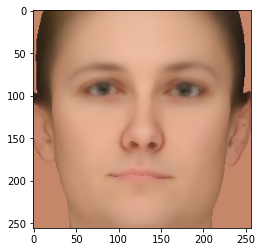

In [ ]:
AugmentPipe